In [ ]:
# Solving the Problem Using darts library 

# 0. Oil Price Prediction

## Objective:

Oil is a product that goes completely in a different direction for a single market event as the oil prices are rarely based on real-time data, instead, it is driven by externalities making our attempt to forecast it even more challenging As the economy will be highly affected by oil prices our model will help to understand the pattern in prices to help the customers and businesses to make smart decisions.

### Sample Data Set Details:

*Extraction the data from various web sources.*

The following data is extracted from: [eia](https://www.eia.gov/)

# 1. Importing Libraries

In [4]:
# DARTS Library for Forecasting

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

# Importing the libraries

import darts
import numpy as np
import time

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import VARIMA, StatsForecastAutoARIMA, FFT, TCNModel, TransformerModel, LightGBMModel, CatBoostModel, Prophet, RNNModel, TFTModel, DLinearModel, NLinearModel, NaiveSeasonal, NBEATSModel, ExponentialSmoothing, NHiTSModel, ARIMA
from darts.metrics import mase, mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper, InvertibleDataTransformer
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist, plot_pacf
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts.models import MovingAverage


from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm import tqdm

import sklearn
from sklearn import preprocessing

import pandas as pd
import torch
import matplotlib.pyplot as plt
import gc

%matplotlib inline
torch.manual_seed(1); np.random.seed(1)  # for reproducibility
import warnings
warnings.filterwarnings('ignore')

# 2. Import Data

In [2]:
# Importing data-set
df_oil = pd.read_csv('oil data update.csv')
df_oil.head(10)

,Date,Price
0,02-01-1986,25.56
1,03-01-1986,26.00
2,06-01-1986,26.53
3,07-01-1986,25.85
4,08-01-1986,25.87
5,09-01-1986,26.03
6,10-01-1986,25.65
7,13-01-1986,25.08
8,14-01-1986,24.97
9,15-01-1986,25.18


# 3.Data Manipulation

## 3.1. Conveting data to Time Seires 

In [5]:
# Oil Price
# import data 
# Convert it to timeseries

oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'Date', 
                                value_cols = ['Price'],
                                freq = 'D')

oil = oil.astype(np.float32)
oil 

<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[11.13]],

       [[13.8 ]],

       [[  nan]],

       ...,

       [[75.19]],

       [[76.09]],

       [[78.29]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 3.1.1. Checking seasonality of the data set.

In [6]:
# Adfuller test output for stationarity of the data
check_seasonality(oil, m=None, max_lag=24, alpha=0.05)

(False, 0)

In [7]:
from matplotlib.pyplot import figure

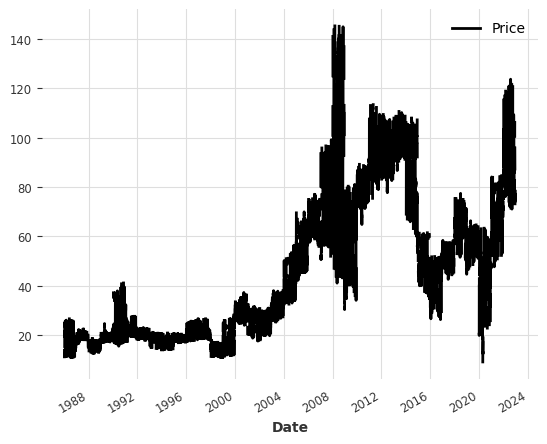

In [8]:
oil.plot()

In [9]:
# filling Missing Values
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")

In [10]:
# output after filling missing values
oil_filler

Filler

In [11]:
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

In [12]:
oil_pipeline = Pipeline([oil_filler, oil_scaler])

In [13]:
oil_pipeline

Pipeline: Filler -> Scaler

In [14]:
### Transfering data to stationary one 

In [15]:
oil_transformed = oil_pipeline.fit_transform(oil)

In [16]:
oil_transformed

<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[0.01519266]],

       [[0.03478899]],

       [[0.02961468]],

       ...,

       [[0.48535782]],

       [[0.49196327]],

       [[0.5081101 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [17]:
# Adfuller test output for stationarity of the data
check_seasonality(oil_transformed, m=None, max_lag=24, alpha=0.05)

(True, 23)

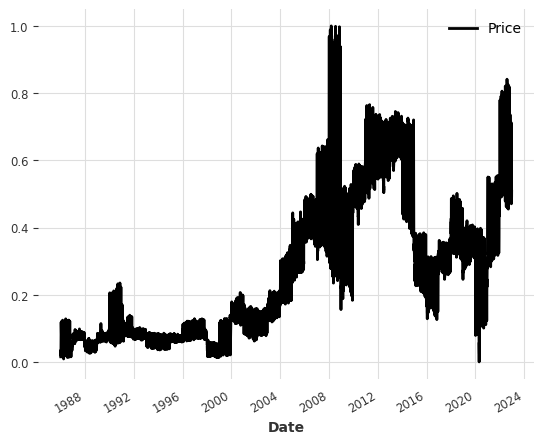

In [18]:
oil_transformed.plot()

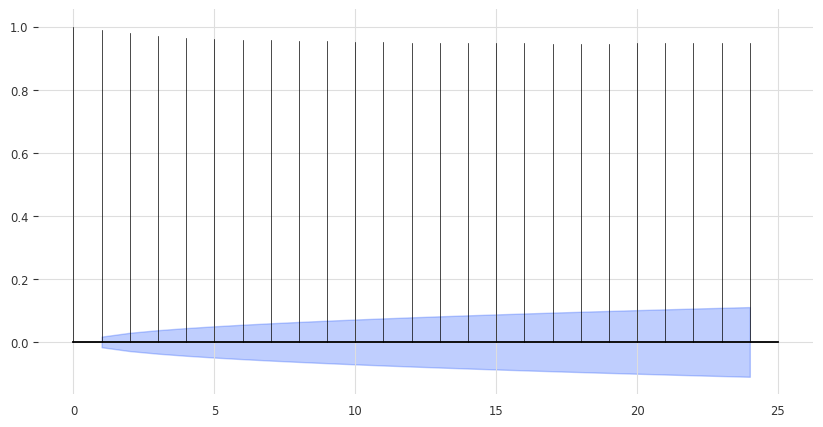

In [19]:
plot_acf(oil_transformed)

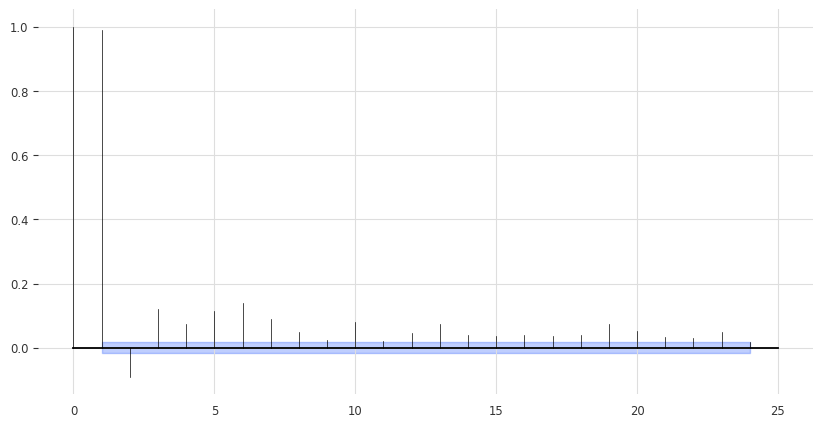

In [20]:
plot_pacf(oil_transformed)

In [21]:
final_transformed = TimeSeries.pd_dataframe(oil_transformed)

In [22]:
final_transformed
# This is the data frame of scaled and transformed data set.

component,Price
Date,
1986-01-04,0.015193
1986-01-05,0.034789
1986-01-06,0.029615
1986-01-07,0.024440
1986-01-08,0.018349
...,...
2022-12-17,0.480954
2022-12-18,0.483156
2022-12-19,0.485358


## 3.2. Inverse Transform of the data to see the final outputs

In [23]:
output = oil_pipeline.inverse_transform(oil_transformed, partial=True)

In [24]:
output

<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[11.13    ]],

       [[13.8     ]],

       [[13.095001]],

       ...,

       [[75.19    ]],

       [[76.09    ]],

       [[78.29    ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

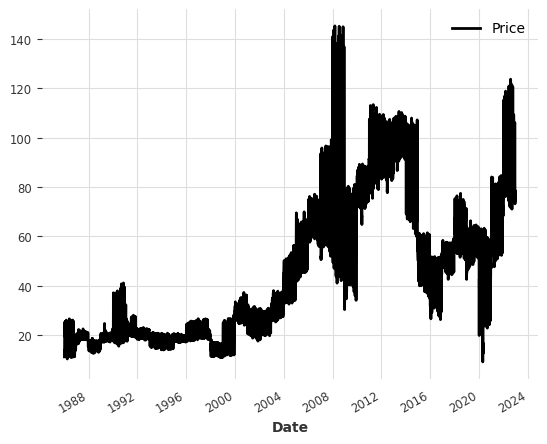

In [25]:
output.plot()

In [26]:
df_output = TimeSeries.pd_dataframe(output)

In [27]:
# Data frame of stationary data after post inverse transformation.
df_output

component,Price
Date,
1986-01-04,11.130000
1986-01-05,13.800000
1986-01-06,13.095001
1986-01-07,12.390000
1986-01-08,11.560000
...,...
2022-12-17,74.590004
2022-12-18,74.889999
2022-12-19,75.190002


In [28]:
# Transfering the data frame to csv file for futer use.
df_output.to_csv('post_transform.csv')

# 4. Moving Averages of the data 

In [29]:
# Moving Averages for Oil Price for 7 days
oil_moving_average_7 = MovingAverage(window=7)

In [30]:
# Moving Averages for Oil Price for 28 days
oil_moving_average_28 = MovingAverage(window=28)

In [31]:
oil_moving_averages = []

In [32]:
ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)

In [33]:
ma_7.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.02600917]],

       [[0.02447706]],

       [[0.0257003 ]],

       [[0.02849803]],

       [[0.0328283 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) <U20 'rolling_mean_7_Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [34]:
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")

In [35]:
ma_7.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.02600917]],

       [[0.02447706]],

       [[0.0257003 ]],

       [[0.02849803]],

       [[0.0328283 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_7'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [36]:
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)

In [37]:
ma_28.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06141546]],

       [[0.06407502]],

       [[0.06605045]],

       [[0.06746249]],

       [[0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) <U21 'rolling_mean_28_Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [38]:
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")

In [39]:
ma_28.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06141546]],

       [[0.06407502]],

       [[0.06605045]],

       [[0.06746249]],

       [[0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [40]:
oil_moving_averages = ma_7.stack(ma_28)

In [41]:
oil_moving_averages.head()

<TimeSeries (DataArray) (Date: 5, component: 2, sample: 1)>
array([[[0.02600917],
        [0.06141546]],

       [[0.02447706],
        [0.06407502]],

       [[0.0257003 ],
        [0.06605045]],

       [[0.02849803],
        [0.06746249]],

       [[0.0328283 ],
        [0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_7' 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 4.1. Moving Average plots

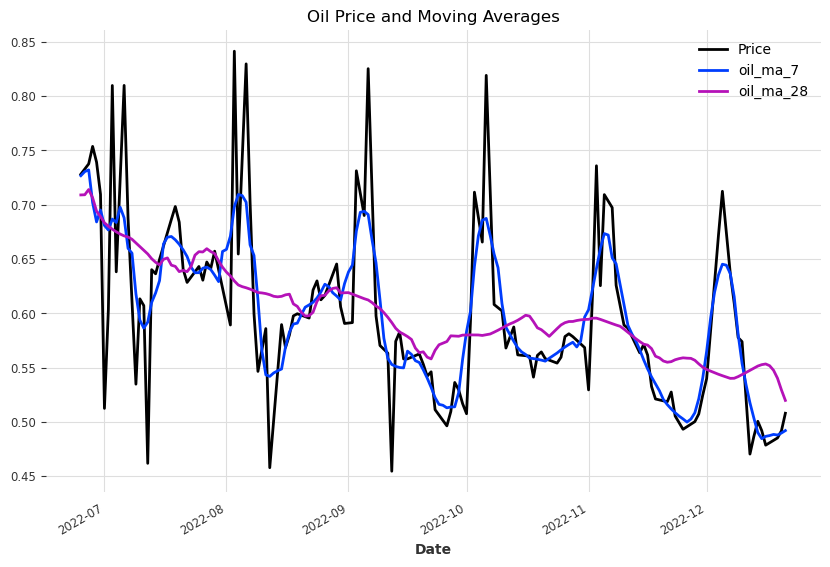

In [42]:
plt.figure(figsize=(10, 6))
oil_transformed[-180:].plot()
oil_moving_averages[-180:].plot()
plt.title("Oil Price and Moving Averages");

In [43]:
output.to_csv('post_data_conversion.csv')

In [44]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13501 entries, 1986-01-04 to 2022-12-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   13501 non-null  float32
dtypes: float32(1)
memory usage: 158.2 KB


In [45]:
# Adfuller test output for stationarity of the data
check_seasonality(output, m=None, max_lag=24, alpha=0.05)

(True, 23)

# 5. Splitting data set (for train and validation)

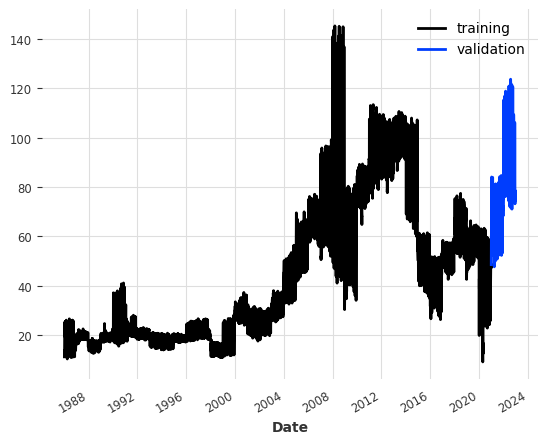

In [46]:
train, val = output.split_before(pd.Timestamp('2020-12-31'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [47]:
# Training Dataset
train

<TimeSeries (DataArray) (Date: 12780, component: 1, sample: 1)>
array([[[11.13    ]],

       [[13.8     ]],

       [[13.095001]],

       ...,

       [[47.62    ]],

       [[48.      ]],

       [[48.4     ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2020-12-30
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [48]:
# Validation Dataset
val

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[ 48.52    ]],

       [[ 51.035   ]],

       [[ 53.55    ]],

       [[ 60.64    ]],

       [[ 61.45    ]],

       [[ 64.585   ]],

       [[ 67.72    ]],

       [[ 75.23    ]],

       [[ 71.91001 ]],

       [[ 68.59    ]],

...

       [[ 73.17    ]],

       [[ 75.39    ]],

       [[ 77.28    ]],

       [[ 76.11    ]],

       [[ 74.29    ]],

       [[ 74.590004]],

       [[ 74.89    ]],

       [[ 75.19    ]],

       [[ 76.09    ]],

       [[ 78.29    ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# 6. Model Building 

## 6.1 ARIMA 

In [49]:
# from darts.models Arima building
model1 = ARIMA()
model1.fit(train)
prediction1 = model1.predict(len(val), num_samples=100)

In [50]:
prediction1 

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 100)>
array([[[ 48.50650407,  48.50650407,  48.50650407, ...,  48.50650407,
          48.50650407,  48.50650407]],

       [[ 46.61603559,  52.52313809,  42.86192437, ...,  47.92034956,
          45.3460836 ,  48.45021623]],

       [[ 47.12330564,  53.09556705,  48.29023884, ...,  49.78484558,
          45.73919844,  48.81691967]],

       ...,

       [[ 70.02633179,  -9.84871191,   9.82467385, ...,  -0.16439018,
          98.70589185, -34.78382065]],

       [[ 74.16498644, -17.53201759,   6.32824915, ...,   4.3218095 ,
         101.7425949 , -32.92530928]],

       [[ 74.98872946, -15.41431689,   7.32496533, ...,   5.68978834,
          98.49125987, -30.06447795]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [51]:
df_prediction1 = TimeSeries.pd_dataframe(prediction1)
df_prediction1

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Price_s0,Price_s1,Price_s2,Price_s3,Price_s4,Price_s5,Price_s6,Price_s7,Price_s8,Price_s9,...,Price_s90,Price_s91,Price_s92,Price_s93,Price_s94,Price_s95,Price_s96,Price_s97,Price_s98,Price_s99
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,...,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504
2021-01-01,46.616036,52.523138,42.861924,46.265127,47.779011,48.941749,45.442813,51.259295,45.704675,52.138079,...,42.235647,49.335235,52.348617,45.336268,45.324803,47.041483,45.413076,47.920350,45.346084,48.450216
2021-01-02,47.123306,53.095567,48.290239,43.466150,44.075189,46.766842,46.887481,55.355503,42.754585,53.243836,...,38.959707,51.285592,54.844945,43.202486,50.252727,42.889458,47.141494,49.784846,45.739198,48.816920
2021-01-03,45.953599,48.838863,51.408382,46.613706,43.875886,43.215710,42.387063,54.696528,36.632393,55.942276,...,36.744988,51.427145,53.425769,38.233300,51.735396,38.990878,46.090911,53.973765,42.069039,49.189285
2021-01-04,40.149270,46.541320,51.068099,50.599705,36.409612,46.158326,41.645559,54.178771,35.683654,54.405963,...,38.909993,53.445508,43.769949,45.357652,52.990992,39.093659,45.951986,54.653731,37.704401,60.052651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,72.430552,-8.020346,-0.191889,36.314016,31.436690,-40.470571,102.052349,-20.495921,10.181074,176.069377,...,146.703166,75.400543,105.871653,27.125146,69.004635,46.278136,72.472188,-4.287884,91.618811,-27.817978
2022-12-18,69.226698,-7.868161,6.919301,39.209073,34.531800,-33.166702,101.281880,-28.297335,11.288876,175.997002,...,146.052686,77.130131,103.759106,28.206549,72.910947,52.449357,68.760256,-7.740979,96.241376,-32.558091
2022-12-19,70.026332,-9.848712,9.824674,36.090948,34.093396,-30.736524,103.639868,-29.757991,3.784253,173.552235,...,148.060156,78.742593,103.818870,27.710038,77.093135,54.380861,72.214083,-0.164390,98.705892,-34.783821


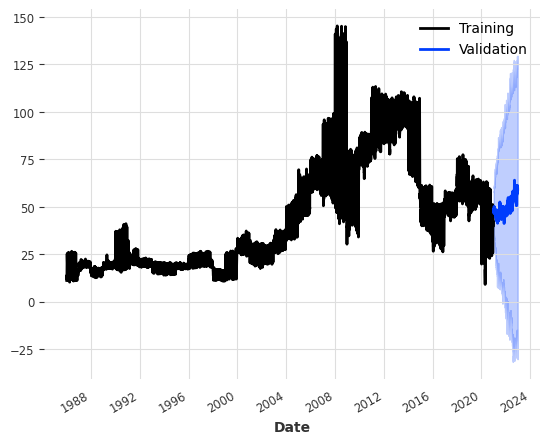

In [52]:
train.plot(label='Training')
prediction1.plot(label='Validation')
plt.legend();

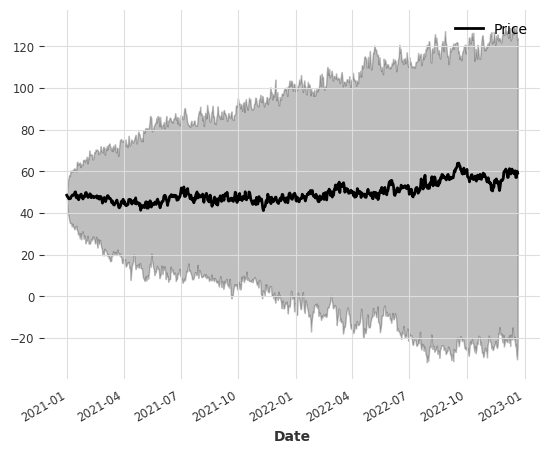

In [53]:
prediction1.plot()

In [54]:
# Converting arima model prediction to a data frame
df_prediction1 = TimeSeries.pd_dataframe(prediction1)
df_prediction1

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Price_s0,Price_s1,Price_s2,Price_s3,Price_s4,Price_s5,Price_s6,Price_s7,Price_s8,Price_s9,...,Price_s90,Price_s91,Price_s92,Price_s93,Price_s94,Price_s95,Price_s96,Price_s97,Price_s98,Price_s99
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,...,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504,48.506504
2021-01-01,46.616036,52.523138,42.861924,46.265127,47.779011,48.941749,45.442813,51.259295,45.704675,52.138079,...,42.235647,49.335235,52.348617,45.336268,45.324803,47.041483,45.413076,47.920350,45.346084,48.450216
2021-01-02,47.123306,53.095567,48.290239,43.466150,44.075189,46.766842,46.887481,55.355503,42.754585,53.243836,...,38.959707,51.285592,54.844945,43.202486,50.252727,42.889458,47.141494,49.784846,45.739198,48.816920
2021-01-03,45.953599,48.838863,51.408382,46.613706,43.875886,43.215710,42.387063,54.696528,36.632393,55.942276,...,36.744988,51.427145,53.425769,38.233300,51.735396,38.990878,46.090911,53.973765,42.069039,49.189285
2021-01-04,40.149270,46.541320,51.068099,50.599705,36.409612,46.158326,41.645559,54.178771,35.683654,54.405963,...,38.909993,53.445508,43.769949,45.357652,52.990992,39.093659,45.951986,54.653731,37.704401,60.052651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,72.430552,-8.020346,-0.191889,36.314016,31.436690,-40.470571,102.052349,-20.495921,10.181074,176.069377,...,146.703166,75.400543,105.871653,27.125146,69.004635,46.278136,72.472188,-4.287884,91.618811,-27.817978
2022-12-18,69.226698,-7.868161,6.919301,39.209073,34.531800,-33.166702,101.281880,-28.297335,11.288876,175.997002,...,146.052686,77.130131,103.759106,28.206549,72.910947,52.449357,68.760256,-7.740979,96.241376,-32.558091
2022-12-19,70.026332,-9.848712,9.824674,36.090948,34.093396,-30.736524,103.639868,-29.757991,3.784253,173.552235,...,148.060156,78.742593,103.818870,27.710038,77.093135,54.380861,72.214083,-0.164390,98.705892,-34.783821


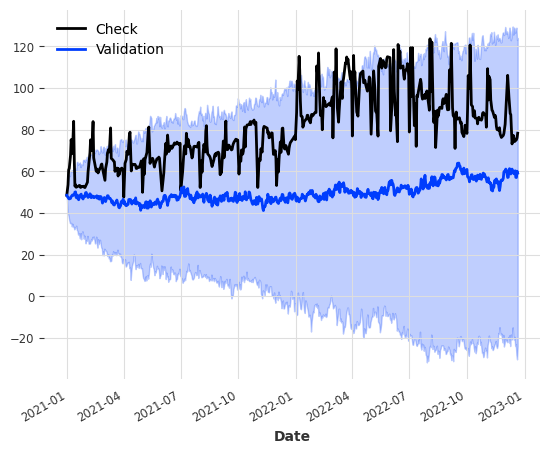

In [55]:
val.plot(label='Check')
prediction1.plot(label='Validation')
plt.legend();

### 6.1.1. Model Evaluation

In [56]:
score_model1_mape = mape(val, prediction1)
score_model1_mape

36.47105223400482

In [57]:
score_model1_mase = mase(val, prediction1 ,train)
score_model1_mase

18.23036751736819

## 6.2. Exponential Smoothing

In [58]:
# from darts.models import ExponentialSmoothing
model2 = ExponentialSmoothing()
model2.fit(train)
prediction2 = model2.predict(len(val), num_samples=100)

In [59]:
prediction2 

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 100)>
array([[[   55.11978634,    49.86446581,    52.09383619, ...,
            55.20385538,    48.81160578,    49.87152541]],

       [[   62.64864893,    44.78021691,    47.37685106, ...,
            58.6523405 ,    57.22299028,    55.1305122 ]],

       [[   62.36717982,    44.42028561,    52.26653386, ...,
            61.91534697,    56.62995901,    57.4415978 ]],

       ...,

       [[-1826.03201298, -1058.90447125,   -65.74970951, ...,
          -610.96196912,  1672.19056652, -1052.86355871]],

       [[-1836.63157234, -1057.49575569,   -61.07920839, ...,
          -619.71787795,  1677.1110374 , -1060.74180978]],

       [[-1842.76068301, -1066.48471741,   -59.32731928, ...,
          -621.26119718,  1682.92196966, -1066.72864157]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [60]:
df_prediction2 = TimeSeries.pd_dataframe(prediction2)
df_prediction2

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Price_s0,Price_s1,Price_s2,Price_s3,Price_s4,Price_s5,Price_s6,Price_s7,Price_s8,Price_s9,...,Price_s90,Price_s91,Price_s92,Price_s93,Price_s94,Price_s95,Price_s96,Price_s97,Price_s98,Price_s99
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,55.119786,49.864466,52.093836,56.957135,55.518611,44.556974,51.983445,47.739387,47.924872,49.904698,...,46.769082,53.032881,49.125111,52.085749,49.695732,51.045139,48.363050,55.203855,48.811606,49.871525
2021-01-01,62.648649,44.780217,47.376851,61.022438,51.283564,51.989482,50.564668,44.901951,55.382714,55.719525,...,41.799864,54.269564,49.059590,47.763043,51.815642,50.529852,51.398972,58.652341,57.222990,55.130512
2021-01-02,62.367180,44.420286,52.266534,64.645129,54.538408,46.524629,51.222390,42.615747,57.346423,56.245033,...,39.836603,53.287347,58.629827,44.343137,52.072923,55.657026,52.538207,61.915347,56.629959,57.441598
2021-01-03,57.825145,50.675620,51.929955,62.578600,57.307310,44.717399,46.180592,37.239790,60.334707,55.909772,...,41.737540,52.606867,57.595739,37.987843,51.082257,52.961508,55.992249,66.773929,62.580055,61.041174
2021-01-04,56.008892,46.599097,55.172385,64.599208,50.948970,46.130672,49.420017,37.266229,60.187920,53.218674,...,37.702409,51.562268,62.327879,42.810130,61.729781,53.008355,53.870418,65.565066,59.287297,61.327766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,-1800.988497,-1060.518704,-74.694395,-1408.791169,931.839432,3221.863819,1963.986472,672.174592,388.178817,736.022763,...,-2329.265785,1351.743684,223.174446,438.874390,-337.346598,884.372116,316.599926,-609.372120,1664.488103,-1046.068106
2022-12-18,-1812.696667,-1057.374517,-69.522481,-1418.199121,933.441569,3232.377195,1959.638573,672.790895,387.095523,741.940591,...,-2326.762429,1348.448027,228.804640,443.185376,-332.760678,876.388712,309.574155,-608.148272,1666.063092,-1049.955057
2022-12-19,-1826.032013,-1058.904471,-65.749710,-1420.066684,935.458727,3237.963716,1954.311522,684.215459,385.512578,749.781145,...,-2332.555823,1353.171849,232.097991,445.727285,-329.964575,871.918889,306.802493,-610.961969,1672.190567,-1052.863559


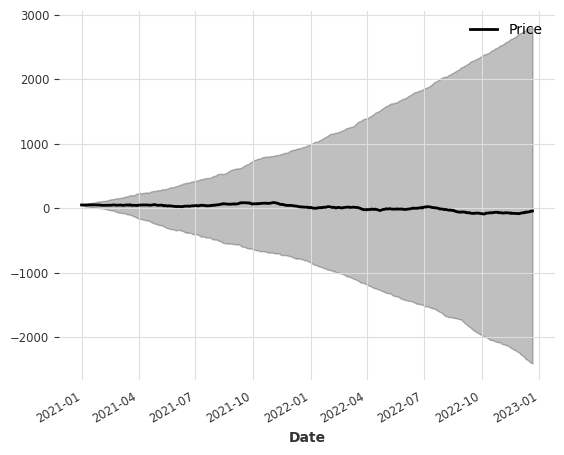

In [61]:
prediction2.plot()

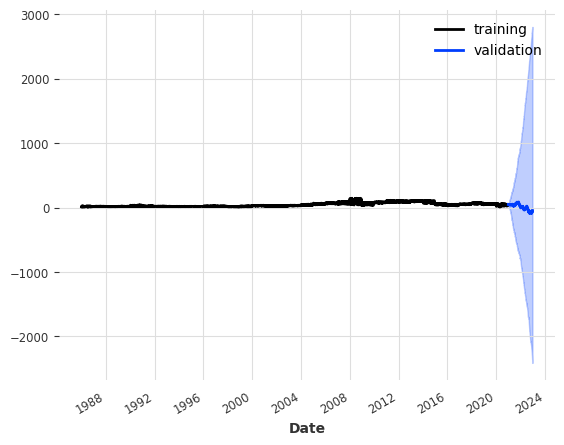

In [62]:
train.plot(label='training')
prediction2.plot(label='validation')
plt.legend();

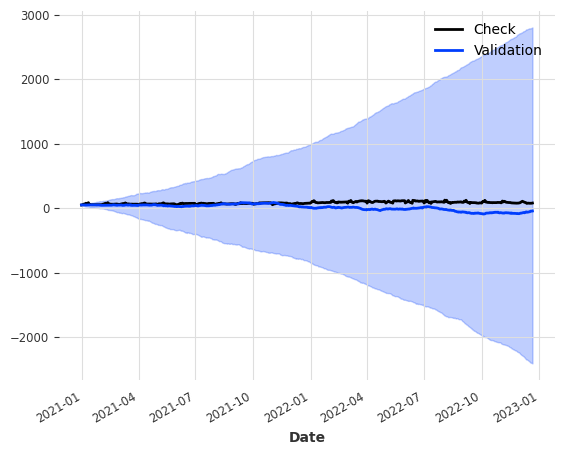

In [63]:
val.plot(label='Check')
prediction2.plot(label='Validation')
plt.legend();

### 6.2.1. Model Evaluation

In [64]:
score_model2_mape = mape(val, prediction2)
score_model2_mape

80.86585068878941

In [65]:
score_model2_mase = mase(val, prediction2, train)
score_model2_mase

41.71939704230248

## 6.3 StatsForecastAutoARIMA

In [66]:
# from darts.models Arima building
model3 = StatsForecastAutoARIMA()
model3.fit(train)
prediction3 = model3.predict(len(val), num_samples=100)

In [67]:
prediction3

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 100)>
array([[[43.38405218, 48.66590991, 48.23077752, ..., 44.45864302,
         45.68163438, 47.52473209]],

       [[43.21332227, 44.6843814 , 49.59494932, ..., 47.49407932,
         48.6719528 , 47.20310349]],

       [[47.5664421 , 38.75524519, 45.41990517, ..., 39.55063342,
         53.10811674, 46.64898348]],

       ...,

       [[29.3274104 , 47.24584814, 48.88139187, ..., 61.12618634,
         39.70224824, 41.60210633]],

       [[72.60213046, 37.23906059, 17.62468973, ..., 34.68649259,
         34.91745577, 45.64890802]],

       [[34.61641983, 15.01079892, 35.56725164, ..., 59.84513782,
         38.83367779, 52.67525131]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [68]:
df_prediction3 = TimeSeries.pd_dataframe(prediction3)
df_prediction3

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Price_s0,Price_s1,Price_s2,Price_s3,Price_s4,Price_s5,Price_s6,Price_s7,Price_s8,Price_s9,...,Price_s90,Price_s91,Price_s92,Price_s93,Price_s94,Price_s95,Price_s96,Price_s97,Price_s98,Price_s99
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,43.384052,48.665910,48.230778,49.180726,41.820229,47.598662,58.246728,45.919739,53.571084,49.522449,...,47.258121,46.133264,46.695716,44.524815,50.609546,47.001359,46.585637,44.458643,45.681634,47.524732
2021-01-01,43.213322,44.684381,49.594949,49.324297,45.255521,52.152287,44.548742,43.552645,43.317355,48.381865,...,42.107322,41.073058,53.431043,49.334168,53.320142,49.316705,43.855539,47.494079,48.671953,47.203103
2021-01-02,47.566442,38.755245,45.419905,39.389341,54.668981,33.176384,54.730698,48.587120,49.681079,44.416811,...,45.578642,40.021011,56.090377,43.559044,50.135799,52.380562,49.322346,39.550633,53.108117,46.648983
2021-01-03,46.497176,47.557148,46.917765,43.118212,47.568572,34.087130,48.196826,44.806659,45.374471,38.363781,...,38.700078,44.947640,40.557864,45.353539,39.386299,46.840812,50.030384,38.258200,53.763085,63.835304
2021-01-04,47.394978,38.086451,39.252301,41.771137,50.760709,46.542740,39.699126,44.069041,56.625842,39.294585,...,48.891588,33.404949,41.205840,44.147807,40.417693,39.149605,50.802604,47.619872,51.285967,51.389544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,50.637704,39.070294,61.500279,24.776352,54.245561,67.524902,31.338017,9.237288,44.650417,59.643964,...,81.130219,72.939152,23.813343,27.227688,53.713359,35.377673,45.360944,64.001270,29.194095,32.516811
2022-12-18,60.764052,39.354272,26.748669,54.135623,57.315390,48.199289,50.960559,44.493451,38.745266,19.638040,...,45.045270,50.767188,26.397689,61.135321,32.097413,84.792801,47.453554,54.574250,95.821230,30.162755
2022-12-19,29.327410,47.245848,48.881392,50.326083,11.456549,52.456580,30.111695,39.075072,77.010059,62.956939,...,60.005463,54.576802,41.009025,45.403689,45.269791,63.397016,77.164342,61.126186,39.702248,41.602106


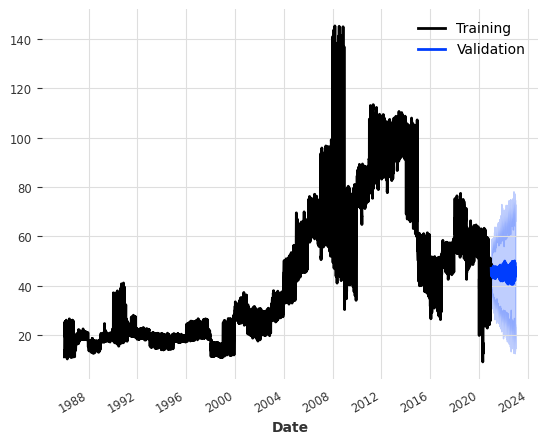

In [69]:
train.plot(label='Training')
prediction3.plot(label='Validation')
plt.legend();

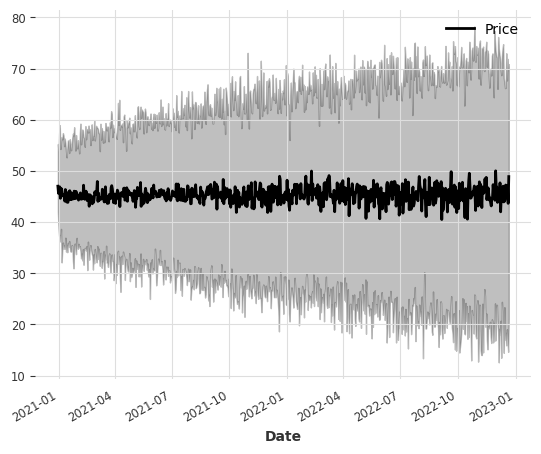

In [70]:
prediction3.plot()

In [71]:
# Converting arima model prediction to a data frame
df_prediction3 = TimeSeries.pd_dataframe(prediction3)
df_prediction3

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Price_s0,Price_s1,Price_s2,Price_s3,Price_s4,Price_s5,Price_s6,Price_s7,Price_s8,Price_s9,...,Price_s90,Price_s91,Price_s92,Price_s93,Price_s94,Price_s95,Price_s96,Price_s97,Price_s98,Price_s99
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,43.384052,48.665910,48.230778,49.180726,41.820229,47.598662,58.246728,45.919739,53.571084,49.522449,...,47.258121,46.133264,46.695716,44.524815,50.609546,47.001359,46.585637,44.458643,45.681634,47.524732
2021-01-01,43.213322,44.684381,49.594949,49.324297,45.255521,52.152287,44.548742,43.552645,43.317355,48.381865,...,42.107322,41.073058,53.431043,49.334168,53.320142,49.316705,43.855539,47.494079,48.671953,47.203103
2021-01-02,47.566442,38.755245,45.419905,39.389341,54.668981,33.176384,54.730698,48.587120,49.681079,44.416811,...,45.578642,40.021011,56.090377,43.559044,50.135799,52.380562,49.322346,39.550633,53.108117,46.648983
2021-01-03,46.497176,47.557148,46.917765,43.118212,47.568572,34.087130,48.196826,44.806659,45.374471,38.363781,...,38.700078,44.947640,40.557864,45.353539,39.386299,46.840812,50.030384,38.258200,53.763085,63.835304
2021-01-04,47.394978,38.086451,39.252301,41.771137,50.760709,46.542740,39.699126,44.069041,56.625842,39.294585,...,48.891588,33.404949,41.205840,44.147807,40.417693,39.149605,50.802604,47.619872,51.285967,51.389544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,50.637704,39.070294,61.500279,24.776352,54.245561,67.524902,31.338017,9.237288,44.650417,59.643964,...,81.130219,72.939152,23.813343,27.227688,53.713359,35.377673,45.360944,64.001270,29.194095,32.516811
2022-12-18,60.764052,39.354272,26.748669,54.135623,57.315390,48.199289,50.960559,44.493451,38.745266,19.638040,...,45.045270,50.767188,26.397689,61.135321,32.097413,84.792801,47.453554,54.574250,95.821230,30.162755
2022-12-19,29.327410,47.245848,48.881392,50.326083,11.456549,52.456580,30.111695,39.075072,77.010059,62.956939,...,60.005463,54.576802,41.009025,45.403689,45.269791,63.397016,77.164342,61.126186,39.702248,41.602106


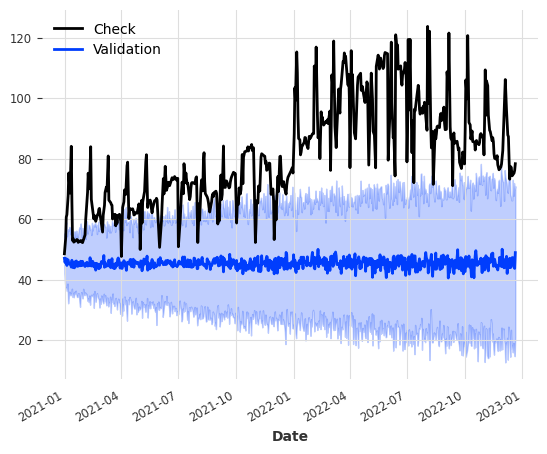

In [72]:
val.plot(label='Check')
prediction3.plot(label='Validation')
plt.legend();

### 6.3.1. Model Evaluation

In [73]:
score_model3_mape = mape(val, prediction3)
score_model3_mape

41.590052949153225

In [74]:
score_model3_mase = mase(val, prediction3,train)
score_model3_mase

20.80369593464912

## 6.4 FFT 

In [75]:
# from darts.models Arima building
model4 = FFT()
model4.fit(train)
prediction4 = model4.predict(len(val))

In [76]:
prediction4

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[28.68689652]],

       [[28.62632569]],

       [[28.56581388]],

       [[28.50536174]],

       [[28.44496991]],

       [[28.38463904]],

       [[28.32436977]],

       [[28.26416276]],

       [[28.20401863]],

       [[28.14393804]],

...

       [[14.21604147]],

       [[14.22437863]],

       [[14.23272821]],

       [[14.24109005]],

       [[14.24946399]],

       [[14.25784988]],

       [[14.26624758]],

       [[14.27465695]],

       [[14.28307784]],

       [[14.2915101 ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [77]:
df_prediction4 = TimeSeries.pd_dataframe(prediction4)
df_prediction4

component,Price
Date,
2020-12-31,28.686897
2021-01-01,28.626326
2021-01-02,28.565814
2021-01-03,28.505362
2021-01-04,28.444970
...,...
2022-12-17,14.257850
2022-12-18,14.266248
2022-12-19,14.274657


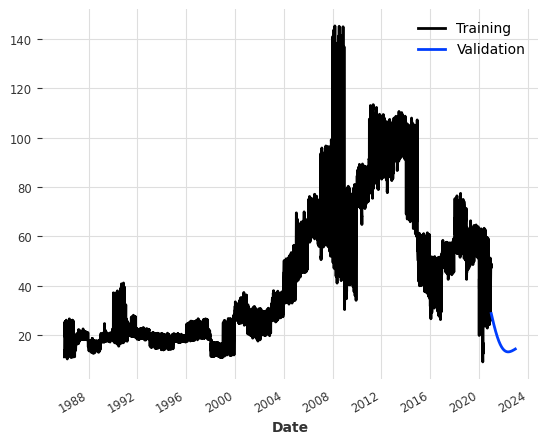

In [78]:
train.plot(label='Training')
prediction4.plot(label='Validation')
plt.legend();

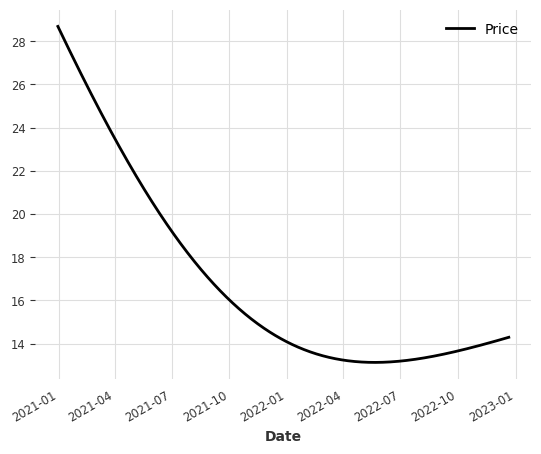

In [79]:
prediction4.plot()

In [80]:
# Converting arima model prediction to a data frame
df_prediction4 = TimeSeries.pd_dataframe(prediction4)
df_prediction4

component,Price
Date,
2020-12-31,28.686897
2021-01-01,28.626326
2021-01-02,28.565814
2021-01-03,28.505362
2021-01-04,28.444970
...,...
2022-12-17,14.257850
2022-12-18,14.266248
2022-12-19,14.274657


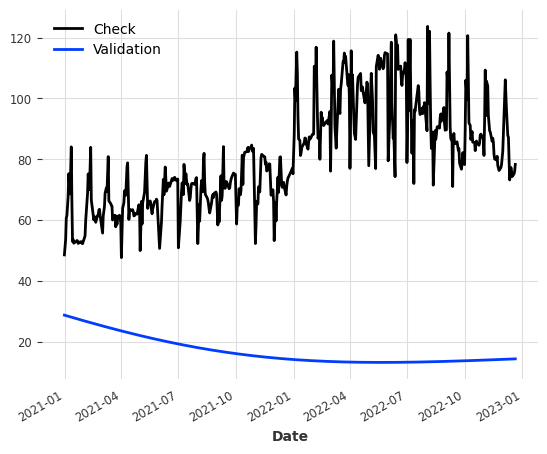

In [81]:
val.plot(label='Check')
prediction4.plot(label='Validation')
plt.legend();

### 6.4.1. Model Evaluation

In [82]:
score_model4_mape = mape(val, prediction4)
score_model4_mape

77.46323003708807

In [83]:
score_model1_mase = mase(val, prediction4 ,train)
score_model1_mase

37.46800117009807

## 6.5 Prophet

In [84]:
# from darts.models Arima building
model5 = Prophet()
model5.fit(train)
prediction5 = model5.predict(len(val))

13:33:18 - cmdstanpy - INFO - Chain [1] start processing
13:33:54 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
prediction5

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[37.43814787]],

       [[37.41836279]],

       [[37.42782006]],

       [[37.51139675]],

       [[37.64201174]],

       [[37.51661422]],

       [[37.55781298]],

       [[37.65921628]],

       [[37.60079435]],

       [[37.56667199]],

...

       [[26.03252977]],

       [[25.81921041]],

       [[25.78406558]],

       [[25.82218358]],

       [[25.71473552]],

       [[25.64673805]],

       [[25.66468983]],

       [[25.7428704 ]],

       [[25.57929433]],

       [[25.59731349]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [86]:
df_prediction5 = TimeSeries.pd_dataframe(prediction5)
df_prediction5

component,Price
Date,
2020-12-31,37.438148
2021-01-01,37.418363
2021-01-02,37.427820
2021-01-03,37.511397
2021-01-04,37.642012
...,...
2022-12-17,25.646738
2022-12-18,25.664690
2022-12-19,25.742870


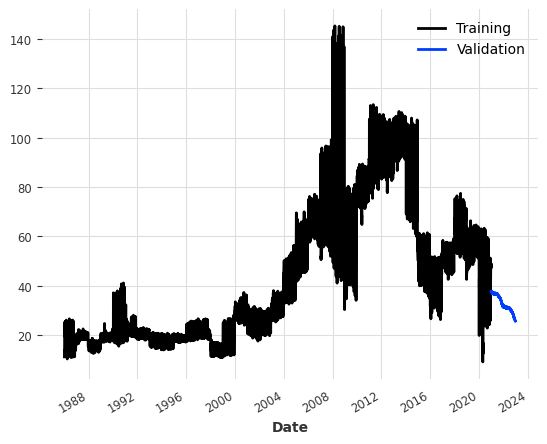

In [87]:
train.plot(label='Training')
prediction5.plot(label='Validation')
plt.legend();

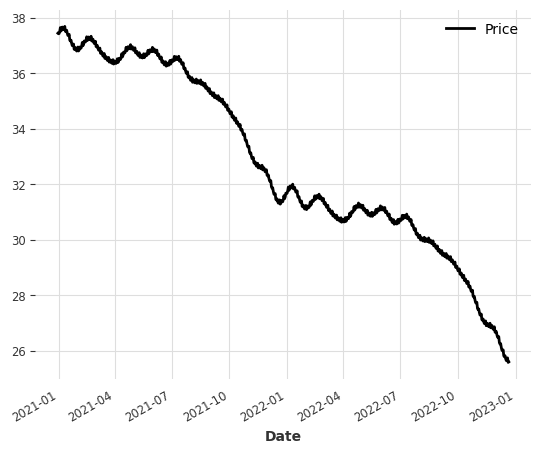

In [88]:
prediction5.plot()

In [89]:
# Converting arima model prediction to a data frame
df_prediction5 = TimeSeries.pd_dataframe(prediction5)
df_prediction5

component,Price
Date,
2020-12-31,37.438148
2021-01-01,37.418363
2021-01-02,37.427820
2021-01-03,37.511397
2021-01-04,37.642012
...,...
2022-12-17,25.646738
2022-12-18,25.664690
2022-12-19,25.742870


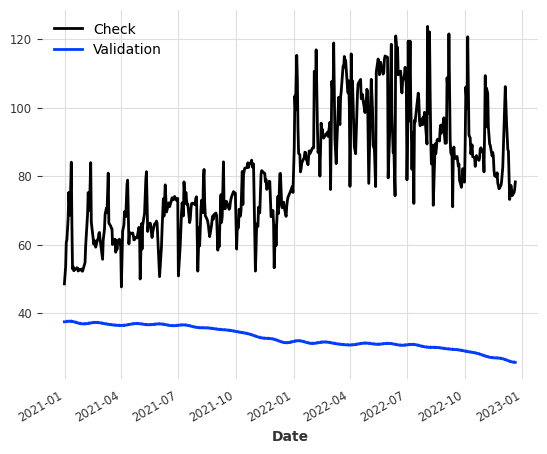

In [90]:
val.plot(label='Check')
prediction5.plot(label='Validation')
plt.legend();

### 6.5.1. Model Evaluation

In [91]:
score_model5_mape = mape(val, prediction5)
score_model5_mape

57.14686994186423

In [92]:
score_model5_mase = mase(val, prediction5 ,train)
score_model5_mase

28.13417024304185

# Neural Network Based Models

## 6.6 RNNModel (Vanila RNN)

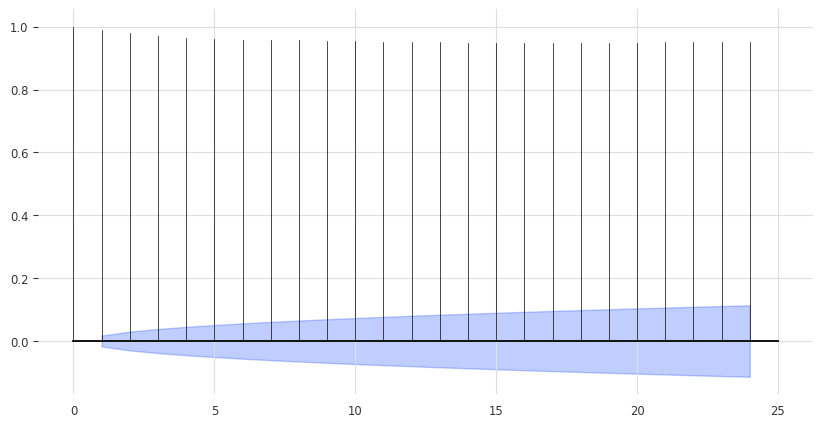

In [93]:
# acf plot of training data
plot_acf(train)

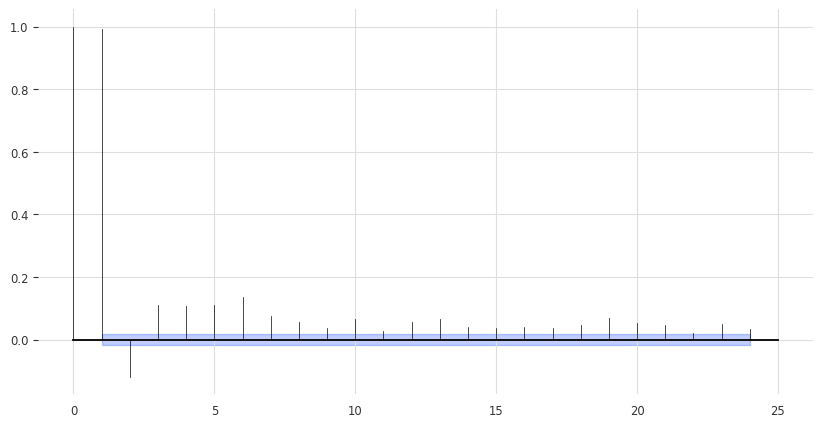

In [94]:
# pacf plot of training data
plot_pacf(train)

In [95]:
# from darts.models Arima building
model6 = RNNModel(input_chunk_length= 15 , # Input window size
    output_chunk_length=1, # Output window size
    hidden_dim=25, # Number of neurons in the hidden layer
    n_rnn_layers=3, # Number of layers in the RNN
    dropout=0.5, # Dropout rate
    batch_size=16, # Number of input-output pairs in each training batch
    n_epochs=50, # Number of training epochs
    # optimizer_kwargs={'lr': 1e-3} # Optimizer parameters
)
model6.fit(train)
prediction6 = model6.predict(len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 3.3 K 
4 | V             | Linear           | 26    
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [96]:
prediction6

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[46.600845]],

       [[43.86077 ]],

       [[41.703163]],

       [[40.807224]],

       [[40.658207]],

       [[40.769108]],

       [[40.838085]],

       [[40.779316]],

       [[40.72457 ]],

       [[40.7275  ]],

...

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]],

       [[40.745365]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [97]:
df_prediction6 = TimeSeries.pd_dataframe(prediction6)
df_prediction6

component,Price
Date,
2020-12-31,46.600845
2021-01-01,43.860771
2021-01-02,41.703163
2021-01-03,40.807224
2021-01-04,40.658207
...,...
2022-12-17,40.745365
2022-12-18,40.745365
2022-12-19,40.745365


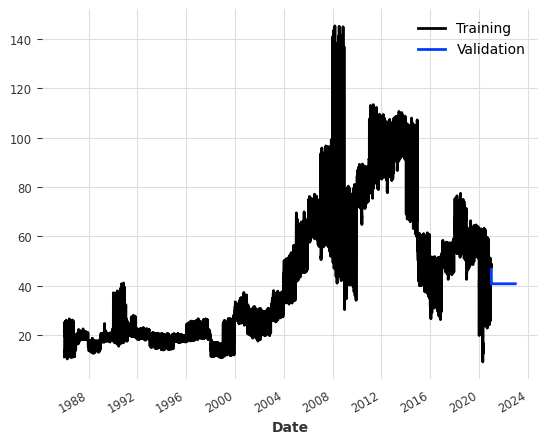

In [98]:
train.plot(label='Training')
prediction6.plot(label='Validation')
plt.legend();

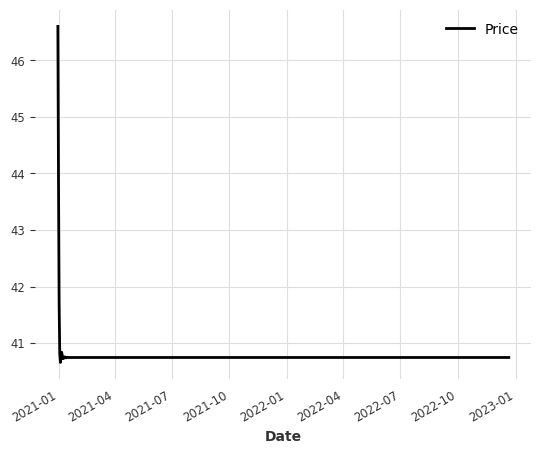

In [99]:
prediction6.plot()

In [100]:
# Converting arima model prediction to a data frame
df_prediction6 = TimeSeries.pd_dataframe(prediction6)
df_prediction6

component,Price
Date,
2020-12-31,46.600845
2021-01-01,43.860771
2021-01-02,41.703163
2021-01-03,40.807224
2021-01-04,40.658207
...,...
2022-12-17,40.745365
2022-12-18,40.745365
2022-12-19,40.745365


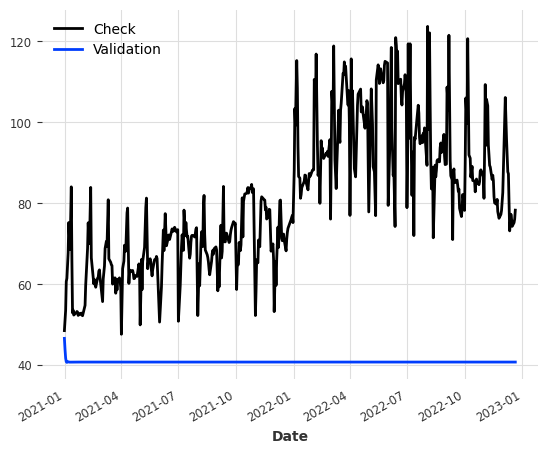

In [101]:
val.plot(label='Check')
prediction6.plot(label='Validation')
plt.legend();

### 6.6.1. Model Evaluation

In [102]:
score_model6_mape = mape(val, prediction6)
score_model6_mape

47.459033131599426

In [103]:
score_model6_mase = mase(val, prediction6 ,train)
score_model6_mase

23.470787

## 6.7 RNN Model (LSTM: Long Short Temporary Model)

In [104]:
# from darts.models Arima building
model7 = RNNModel(model='LSTM',
    hidden_dim=25,
    dropout=0.5,
    batch_size=16,
    n_epochs=50,
    input_chunk_length= 15 , # Input window size
    output_chunk_length=1, # Output window size
    n_rnn_layers=3
)

In [105]:
model7.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 13.2 K
4 | V             | Linear           | 26    
---------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [106]:
prediction7 = model7.predict(len(val), num_samples=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [107]:
prediction7

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[49.904152]],

       [[51.553986]],

       [[53.250355]],

       [[54.96297 ]],

       [[56.451485]],

       [[57.47305 ]],

       [[57.994144]],

       [[58.205875]],

       [[58.295876]],

       [[58.365623]],

...

       [[70.10964 ]],

       [[70.10964 ]],

       [[70.10964 ]],

       [[70.10964 ]],

       [[70.10965 ]],

       [[70.10966 ]],

       [[70.10966 ]],

       [[70.10966 ]],

       [[70.109665]],

       [[70.109665]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [108]:
df_prediction7 = TimeSeries.pd_dataframe(prediction7)
df_prediction7

component,Price
Date,
2020-12-31,49.904152
2021-01-01,51.553986
2021-01-02,53.250355
2021-01-03,54.962971
2021-01-04,56.451485
...,...
2022-12-17,70.109657
2022-12-18,70.109657
2022-12-19,70.109657


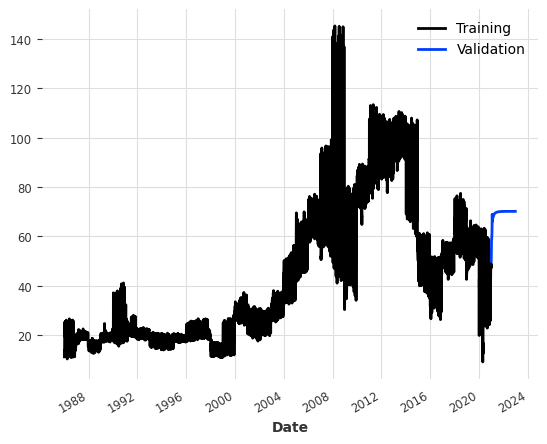

In [109]:
train.plot(label='Training')
prediction7.plot(label='Validation')
plt.legend();

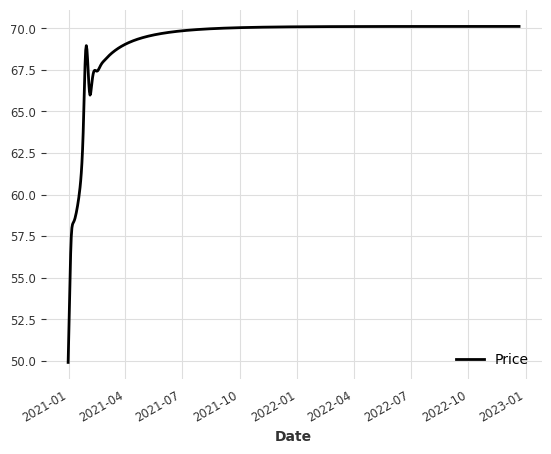

In [110]:
prediction7.plot()

In [111]:
# Converting arima model prediction to a data frame
df_prediction7 = TimeSeries.pd_dataframe(prediction7)
df_prediction7

component,Price
Date,
2020-12-31,49.904152
2021-01-01,51.553986
2021-01-02,53.250355
2021-01-03,54.962971
2021-01-04,56.451485
...,...
2022-12-17,70.109657
2022-12-18,70.109657
2022-12-19,70.109657


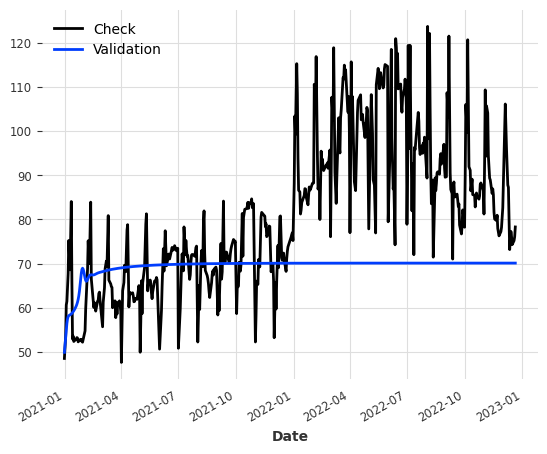

In [112]:
val.plot(label='Check')
prediction7.plot(label='Validation')
plt.legend();

### 6.7.1. Model Evaluation

In [113]:
score_model7_mape = mape(val, prediction7)
score_model7_mape

16.90472960472107

In [114]:
score_model7_mase = mase(val, prediction7 ,train)
score_model7_mase

8.833303

## 6.8 RNN Model (GRU)

In [115]:
# from darts.models Arima building
model8 = RNNModel(model='GRU',
    hidden_dim=25,
    dropout=0.5,
    batch_size=16,
    n_epochs=50,
    input_chunk_length= 15 , # Input window size
    output_chunk_length=1, # Output window size
    n_rnn_layers=3
)

In [116]:
model8.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 9.9 K 
4 | V             | Linear           | 26    
---------------------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [117]:
prediction8 = model8.predict(len(val), num_samples=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [118]:
prediction8

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[48.801006 ]],

       [[49.040276 ]],

       [[49.18644  ]],

       [[49.285706 ]],

       [[49.369324 ]],

       [[49.452393 ]],

       [[49.524727 ]],

       [[49.59325  ]],

       [[49.649696 ]],

       [[49.700394 ]],

...

       [[ 3.098907 ]],

       [[ 3.0933032]],

       [[ 3.0877223]],

       [[ 3.0821662]],

       [[ 3.0766273]],

       [[ 3.071113 ]],

       [[ 3.0656219]],

       [[ 3.0601497]],

       [[ 3.0547004]],

       [[ 3.0492702]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [119]:
df_prediction8 = TimeSeries.pd_dataframe(prediction8)
df_prediction8

component,Price
Date,
2020-12-31,48.801006
2021-01-01,49.040276
2021-01-02,49.186440
2021-01-03,49.285706
2021-01-04,49.369324
...,...
2022-12-17,3.071113
2022-12-18,3.065622
2022-12-19,3.060150


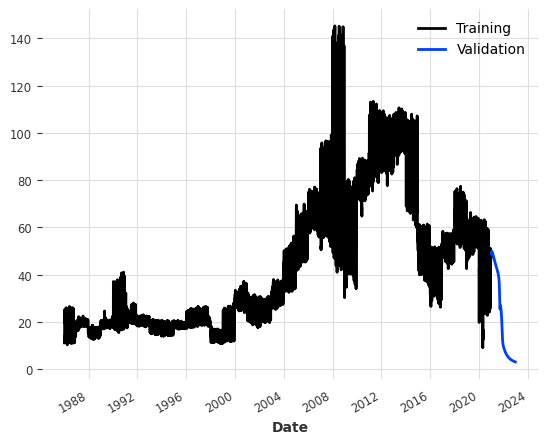

In [120]:
train.plot(label='Training')
prediction8.plot(label='Validation')
plt.legend();

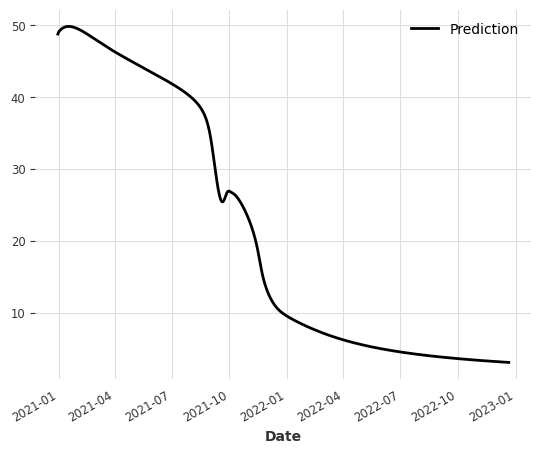

In [121]:
prediction8.plot(label='Prediction')
# val.plot(label='valisation set')

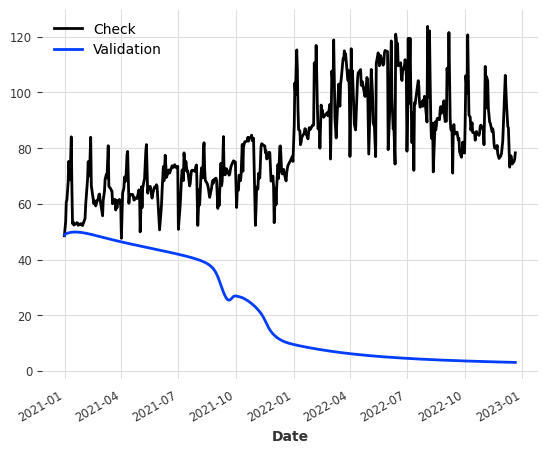

In [122]:
val.plot(label='Check')
prediction8.plot(label='Validation')
plt.legend();

### 6.8.1. Model Evaluation

In [123]:
score_model8_mape = mape(val, prediction8)
score_model8_mape

68.9201831817627

In [124]:
score_model8_mase = mase(val, prediction8 ,train)
score_model8_mase

34.943146

# Serializing and dumping Model 

In [125]:
import pickle as pkl

# Dump the model to disk using pickle
filename = 'model6.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model6, file)

In [126]:
# Dump the model to disk using pickle
filename = 'model7.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model7, file)

In [127]:
# Dump the model to disk using pickle
filename = 'model1.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model1, file)

In [128]:
# Dump the model to disk using pickle
filename = 'model2.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model2, file)

In [129]:
# Dump the model to disk using pickle
filename = 'model3.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model3, file)

In [130]:
# Dump the model to disk using pickle
#filename = 'model4.pkl'
#with open(filename, 'wb') as file:
    #pkl.dump(model4, file)

In [131]:
# Dump the model to disk using pickle
filename = 'model5.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model5, file)

In [132]:
# Dump the model to disk using pickle
filename = 'model8.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model8, file)

# Deployment Pickle

In [133]:
#import pickle
#pickle_out = open("bag.pkl","wb")
#pickle.dump(bag, pickle_out)
#pickle_out.close()

In [134]:
from pickle import dump
dump([model1,model2,model3,model5,model6,model7,model8],
open('allmodels_1.sav','wb'))

In [142]:
import dill as pickle
from pickle import dump
dump([model1,model2,model3,model4,model5,model6,model7,model8],
open('allmodels_1.sav','wb'))

AttributeError: Can't pickle local object 'FFT.fit.<locals>.<lambda>'

In [140]:
from pickle import dump
dump([model1,model2,model3,model4,model5,model6,model7,model8],
open('allmodels_1.sav','wb'))

AttributeError: Can't pickle local object 'FFT.fit.<locals>.<lambda>'

In [ ]:
# Old project code
#  from pickle import dump
# dump([logisticlassifier,MNB,KNN_classifier,model_linear,dt,bag,RFC],
# open('allmodels_1.sav','wb'))

In [143]:
import pickle

In [144]:
from pickle import dump
# Load the saved model from disk
with open('model5.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [145]:
loaded_model.predict(3)

<TimeSeries (DataArray) (Date: 3, component: 1, sample: 1)>
array([[[37.43814787]],

       [[37.41836279]],

       [[37.42782006]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 2021-01-02
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None